<a href="https://colab.research.google.com/github/zyang63/Gate_design/blob/main/Gate_design_and_flow_simulation_with_flow_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flow Analysis
Imports are made below. The code has been factored to work in colab as well as locally on a computer using anaconda and vs code.


The code installs and imports several libraries for different purposes. The trimesh library is installed to work with triangular meshes, SimpleITK is installed for medical image analysis, scipy is installed for scientific computing, and bpy is installed for 3D modeling and rendering.

In [2]:
%%capture
try:
  import open3d as o3d
except ImportError:
  !pip install open3d
  import open3d as o3d
try:
  import SimpleITK as sitk
except ImportError:
  !pip install SimpleITK
  import SimpleITK as sitk
try:
  import bpy
except ImportError:
  !pip install bpy
  import bpy
try:
  from stl import mesh
except ImportError:
  !pip install numpy-stl
  from stl import mesh
try:
  import pyvista as pv
except ImportError:
  !pip install pyvista
  import pyvista as pv
try:
  from scipy import ndimage
except ImportError:
  !pip install scipy
  from scipy import ndimage
try:
  from skimage import measure
except ImportError:
  !pip install scikit-image
  from skimage import measure
try:
  from google.colab import files
  IN_COLAB = True
except ImportError:
  IN_COLAB = False
try:
  import trimesh as t
  from trimesh.voxel import creation
except ImportError:
  !pip install trimesh
  import trimesh as t
  from trimesh.voxel import creation
try:
  from pygltflib import GLTF2, Animation, AnimationSampler
except ImportError:
  !pip install pygltflib
  from pygltflib import GLTF2, Animation, AnimationSampler
import numpy as np
import os
import math
import bmesh
from mathutils import Vector
import ipywidgets as widgets
from IPython.display import display
import subprocess
import matplotlib.pyplot as plt

In [3]:
%%capture
if IN_COLAB:
  blender_url_dict = {'4.2': "https://download.blender.org/release/Blender4.2/blender-4.2.0-linux-x64.tar.xz"}
  blender_version = '4.2'
  blender_url = blender_url_dict[blender_version]
  base_url = os.path.basename(blender_url)
  !mkdir $blender_version
  !wget -nc $blender_url
  !tar -xkf $base_url -C ./$blender_version --strip-components=1
else:
  blender_path = r'C:\Program Files\Blender Foundation\Blender 4.2\blender.exe'

# Setup

STL file and parameter settings are required in this section. The first cell is to present a button for a file upload dialog. This has only worked in a desktop browser, not in iOS safari. Because of the limitations of this interaction, additional methods need to be explored for ease of use. A flag to determine if this notebook is being run in colab. The cell must be run to set button_pressed and to clear the filename if the default is set in the second cell.

The second cell contains the parameter settings that are used to load the STL file and estimate the element count in a single direction as well as cell size. a prefix string is set either to look at the root of the colab environment or relative to the local directory where the notebook is run for these files.

In [3]:
#@title #File Entry { display-mode: "form"}

button_pressed = False  # Initialize the variable as False
filename = ""
button = widgets.Button(description="Google upload dialog")
output = widgets.Output()

def on_button_clicked(b):
    global button_pressed  # Access the global variable
    global filename
    with output:
        uploaded = files.upload()
        filename = list(uploaded.keys())[0]
        button_pressed = True  # Set the variable to True when the button is clicked

if IN_COLAB:
  button.on_click(on_button_clicked)
  display(button, output)

Button(description='Google upload dialog', style=ButtonStyle())

Output()

In [4]:
#@title #Element Count { display-mode: "form", run: "auto" }
if not button_pressed:
    filename = "/content/Casting_Shot - 8M0111257-1.STL" #@param {type:"string"}
element_count = 200 #@param {type:"slider", min:10, max:500, step:1}
geometry = o3d.io.read_triangle_mesh(os.path.join(os.getcwd(),filename))
max_boundary_size = (geometry.get_max_bound()-geometry.get_min_bound()).max()
mid_boundary_size = np.median(geometry.get_max_bound() - geometry.get_min_bound())
voxel_resolution = max_boundary_size/element_count
print("Element size is in units from stl file ",voxel_resolution, " per cell")
origin = geometry.get_min_bound()

Element size is in units from stl file  0.8853920555114746  per cell


## Parameter setting
These parameters are to set units, injection speed, injection time, and minimum gate thickness.

In [45]:
unit = 0.001 # stl size to m
injection_speed = 60 #m/s
injection_time = 0.04 #s
min_gate_thickness = 0.0025 #m (or 0.0015 m)
voxel_across_gate = min_gate_thickness / (voxel_resolution * unit) # expect 5 domain voxels
flow_scale = 0.8 #this is a linear scaling factor to make the flow inside the gates 0.8*5 = 4 voxels
gate_area_ratio = (injection_speed * injection_time) / ((voxel_resolution * unit) ** 3) #take total count / gate_area_ratio
gate_depth = max_boundary_size * unit * 200
frame_number = 100
size_air_splash = 0.001
voxel_across_air_splash = size_air_splash / (voxel_resolution * unit)

# Voxelizing the geometry


The following code performs voxelization and mesh conversion operations. It starts by voxelizing a mesh with a specified voxel size. Then, it creates a solid voxel representation by filling the voxel surface. The solid voxel data is padded with two layers of zeros. The padded voxel data is further processed using marching cubes algorithm to obtain a mesh representation.

In [12]:
def geometry_process(geometry, voxel_resolution):
  pcd = geometry.sample_points_uniformly(number_of_points=100000000)
  voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd,voxel_size=voxel_resolution)
  voxels = voxel_grid.get_voxels()
  indices = np.stack(list(vx.grid_index for vx in voxels))
  del voxels, voxel_grid, pcd
  max_indices = np.max(indices, axis=0)+1
  dense_array = np.zeros(max_indices, dtype=np.bool_)
  for idx in indices:
      dense_array[tuple(idx)] = 1
  del indices
  array_pad = np.pad(dense_array.astype(bool),((2,2)),'constant')
  del dense_array
  array_closing = ndimage.binary_closing(array_pad, structure=ndimage.generate_binary_structure(3, 1),
  iterations=1, mask=None,  border_value=0, origin=0, brute_force=False)
  img = sitk.GetImageFromArray(array_closing.astype(int))
  seg = sitk.ConnectedComponent(img != img[0,0,0])
  img_filled = sitk.BinaryFillhole(seg!=0)
  array_filled = sitk.GetArrayFromImage(img_filled)
  return img_filled, array_filled

In [14]:
img_filled, array_filled = geometry_process(geometry, voxel_resolution)

# Distance transform, Watershed on mesh


## Distance Field Calculation
The following code calculates the signed Maurer distance map from a binary voxel data representation. The distance map is computed using the SignedMaurerDistanceMap function from the SimpleITK library. The resulting distance map is then converted into a NumPy array. The code further determines the depth of the object by taking the negative minimum value from the distance map and converting it to an integer. This depth value represents the distance inside the object. Overall, these operations provide information about the spatial distribution and depth of the object in the voxel data.

In [15]:
array_initial = ndimage.binary_closing(array_filled, structure=ndimage.generate_binary_structure(3, 1), iterations=1, mask=None,  border_value=0, origin=0, brute_force=False)
img_initial = sitk.GetImageFromArray(array_initial.astype(int))
img_dist = sitk.SignedMaurerDistanceMap(img_initial != 0, insideIsPositive=False, squaredDistance=False, useImageSpacing=False)
array_dist = sitk.GetArrayFromImage(img_dist)

## Watershed Segmentation

In [16]:
img_thresh = img_filled != 0
img_ws = sitk.MorphologicalWatershed(img_dist, markWatershedLine=True, level=1)
img_ws = sitk.Cast(img_ws, img_thresh.GetPixelID())
img_ws_mark = sitk.Mask(img_ws, img_thresh)
array_ws_mark = sitk.GetArrayFromImage(img_ws_mark)

In [17]:
voxel_geometry_test = t.voxel.base.VoxelGrid(array_ws_mark)
voxel_surface_test = voxel_geometry_test.copy().hollow()
points_test = t.points.PointCloud(voxel_surface_test.points,colors=np.tile(np.array([0, 0, 0, 1]), (len(voxel_surface_test.points), 1)))
s = t.Scene()
s.add_geometry(t.creation.axis())
s.add_geometry(points_test)
s.show()

# Find injection direction

## Maximum thickness segmentation data
This code finds the maximum thickness voxel for each segment storing the value of the maximum thickness, the count of all the volumes in that segment as well as the coordinates of the maximum thickness. Note: if multiple values of maximum thickness are found only the first one is returned.

In [11]:
def find_max_thickness(array_ws_mark, array_dist):
  thick = []
  max_segement_id = np.max(array_ws_mark)
  for id in range(1, max_segement_id + 1):
    segment_id = np.where(array_ws_mark == id, array_ws_mark, 0)
    dis_i = np.where(segment_id == 0, 0, array_dist)
    thickness = dis_i[dis_i < 0].min()
    coords = np.argwhere(dis_i == thickness)[0]
    thick.append((id, -thickness, np.count_nonzero(segment_id), tuple(coords)))
  max_thickness = max(thick, key=lambda x: x[1])[1]
  max_thickness_arrays = [item for item in thick if item[1] == max_thickness]
  max_count_arrays = max(max_thickness_arrays, key=lambda x: x[2])
  return thick, max_count_arrays
thick_data, max_thickness = find_max_thickness(array_ws_mark, array_dist)
print(thick_data)
print(max_thickness)

[(1, 9.219544, 22629, (17, 87, 14)), (2, 9.219544, 23763, (17, 115, 14)), (3, 9.0, 16542, (19, 20, 30)), (4, 10.0, 33600, (21, 41, 12)), (5, 10.0, 63495, (21, 161, 12)), (6, 5.656854, 22176, (59, 101, 8)), (7, 9.899495, 41918, (137, 101, 21)), (8, 8.062258, 36069, (138, 25, 11)), (9, 8.062258, 21952, (138, 177, 11)), (10, 10.0, 37617, (154, 50, 30)), (11, 9.69536, 24870, (140, 76, 30)), (12, 9.848858, 24772, (140, 126, 30)), (13, 10.0, 37449, (154, 152, 30)), (14, 9.219544, 31870, (156, 25, 17)), (15, 9.219544, 24030, (156, 177, 17)), (16, 9.899495, 32111, (157, 101, 19)), (17, 5.0990195, 5358, (195, 178, 14))]
(5, 10.0, 63495, (21, 161, 12))


## Injection plane
Finding the injection plane is done by using the maximum thickness coordinates to identify the nearest edge in the x and y directions that are the longest from the stl bounding box.

Single function to get boundary vertices, find the closest line, and the corresponding original vertices


In [12]:
def find_injection_plane(array, point):
    y_max, x_max = array.shape[0] - 1, array.shape[1] - 1
    if y_max > x_max:
        injection_plane_name = '-yz' if point[0] > 0.5 * x_max else 'yz'
        structuring_element = np.ones((3,1,1))
    else:
        injection_plane_name = '-xz' if point[1] > 0.5 * y_max else 'xz'
        structuring_element = np.ones((1,3,1))
    return injection_plane_name,structuring_element
injection_plane_name,structuring_element = find_injection_plane(array_initial, max_thickness[3][:2])
print(injection_plane_name)

yz


## Overlap area
The overlap area is needed to find with surfaces of the part that face the injection plane.

In [13]:
def overlap_injection_plane(array_initial, selected_plane):
    boundary_mask = np.zeros_like(array_initial)
    settings = {'yz': (slice(None), 0, slice(None), 1, 1),
                '-yz': (slice(None), -1, slice(None), 1, -1),
                'xz': (0, slice(None), slice(None), 0, 1),
                '-xz': (-1, slice(None), slice(None), 0, -1)}
    mask_slices, axis, shift = settings[selected_plane][:3], settings[selected_plane][3], settings[selected_plane][4]
    boundary_mask[mask_slices] = 1
    overlap_array = np.zeros_like(array_initial)
    for _ in range(array_initial.shape[axis]):
        boundary_mask = np.roll(boundary_mask, shift=shift, axis=axis)
        overlap = np.logical_and(boundary_mask, array_initial)
        overlap_array = np.where(overlap, 1, overlap_array)
        boundary_mask = np.where(overlap, 0, boundary_mask)
    return overlap_array
overlap_array = overlap_injection_plane(array_initial, injection_plane_name)
iterations_value = math.ceil(min_gate_thickness / (voxel_resolution * unit))
erosion_updated_array = ndimage.binary_erosion(overlap_array, structure=structuring_element, iterations=iterations_value).astype(int)
print(np.max(erosion_updated_array))

1


## Viewing the Overlapped injection plane
The code below is to test and inspect the overlap plane found.

In [14]:
voxel_geometry_test = t.voxel.base.VoxelGrid(erosion_updated_array)
voxel_surface_test = voxel_geometry_test.copy().hollow()
points_test = t.points.PointCloud(voxel_surface_test.points,colors=np.tile(np.array([0, 0, 0, 1]), (len(voxel_surface_test.points), 1)))
s = t.Scene()
s.add_geometry(t.creation.axis())
s.add_geometry(points_test)
s.show()

# Parting Line Analysis

##  Find whole geometry parting line
Sum 3D array along height, essentally project the geometry in the vertical direction. This

In [15]:
def calculate_boundary_indicator(array):
  flattened = np.sum(array, axis=2)
  pad_top = np.pad(flattened[:-1], ((1, 0), (0, 0)), 'constant')
  pad_bottom = np.pad(flattened[1:], ((0, 1), (0, 0)), 'constant')
  pad_left = np.pad(flattened[:, :-1], ((0, 0), (1, 0)), 'constant')
  pad_right = np.pad(flattened[:, 1:], ((0, 0), (0, 1)), 'constant')
  boundary_indicator = ((flattened != 0) & ((pad_top == 0) | (pad_bottom == 0) | (pad_left == 0) | (pad_right == 0))).astype(int)
  return boundary_indicator
def find_parting_line(array_initial):
    B = calculate_boundary_indicator(array_initial)
    N = np.logical_and(array_initial, B[:, :, np.newaxis]).astype(int)
    P = np.zeros_like(B)
    M = np.zeros_like(N)
    while True:
        U = B - P
        V = np.logical_and(N, U[:, :, np.newaxis]).astype(int)
        max_ones_count = np.max(np.sum(V, axis=(0, 1)))
        L = (V * (np.sum(V, axis=(0, 1)) == max_ones_count)).astype(int)
        M[L == 1] = 1
        I = calculate_boundary_indicator(L)
        P = np.maximum(P, I)
        if np.array_equal(P, B): break
    layer_counts = np.sum(M, axis=(0, 1))
    unique_counts, count_occurrences = np.unique(layer_counts, return_counts=True)
    sorted_indices = np.argsort(count_occurrences)[::-1]
    for i, count in enumerate(unique_counts[sorted_indices]):
        M[:, :, layer_counts == count] *= (i + 1)
    return M
M = find_parting_line(array_initial)

## find injection parting line
Overlap injection plane and parting line on geometry

In [16]:
def find_injection_parting_overlap(M, erosion_updated_array, array_ws_mark):
  parting_line = np.logical_and(M, erosion_updated_array)
  values_at_locations = array_ws_mark[parting_line]
  parting_line_seg = np.unique(values_at_locations[values_at_locations != 0])
  mask = np.isin(array_ws_mark, parting_line_seg)
  equal_elements = np.logical_and(mask, M)
  return equal_elements, parting_line_seg
equal_elements, parting_line_seg = find_injection_parting_overlap(M, erosion_updated_array, array_ws_mark)
print(parting_line_seg)

[ 3  4  8 14]


## View injection parting Line

In [17]:
voxel_geometry_test = t.voxel.base.VoxelGrid(equal_elements)
voxel_surface_test = voxel_geometry_test.copy().hollow()
points_test = t.points.PointCloud(voxel_surface_test.points,colors=np.tile(np.array([0, 0, 0, 1]), (len(voxel_surface_test.points), 1)))
s = t.Scene()
s.add_geometry(t.creation.axis())
s.add_geometry(points_test)
s.show()

# Gate located


## Gate size calculating

In [18]:
geometry_count = sum(item[2] for item in thick_data) #total volume count summed over segment count
gate_size = geometry_count  / gate_area_ratio #gate area in voxel count
gate_total_length = gate_size / ((voxel_across_gate)*(voxel_resolution * unit) **2) #gate length for minimum gate thickness
injection_segment_count = sum(thick_data[segment - 1][2] for segment in parting_line_seg)
injection_gate_length = [
    (segment, (thick_data[segment - 1][2] * gate_total_length) / injection_segment_count)
    for segment in parting_line_seg]
injection_gate_length_dict = dict(injection_gate_length)

## Find coordinates data of geometry

In [19]:
def find_gate_and_thick_coordinates(array_ws_mark, array_dist, equal_elements, voxel_resolution,
                                    origin, thick_data, array_initial, geometry):
    def find_closest_face(coordinate, center_array_initial):
        direction_vector = coordinate - center_array_initial
        distances = [np.abs(direction_vector[i % 2]) for i in range(4)]
        return ['xz', 'yz', '-xz', '-yz'][np.argmin(distances)]
    def distance_to_face(point, face_type, geometry):
        x, y, z = point
        min_x, min_y, min_z = geometry.get_min_bound()
        max_x, max_y, max_z = geometry.get_max_bound()
        if face_type == 'xz' or face_type == '-xz':
            dist = min(abs(y - min_y), abs(y - max_y)) + (max_y - min_y) * 0.06
        elif face_type == 'yz' or face_type == '-yz':
            dist = min(abs(x - min_x), abs(x - max_x)) + (max_x - min_x) * 0.06
        return dist
    center_array_initial = np.array(array_initial.shape) / 2
    results = []
    combined_gate_line = np.zeros_like(array_ws_mark, dtype=np.float32)  # Important for accumulating gate lines
    for i, _, _, target_coords in thick_data:
        F_i = (array_ws_mark == i)
        T_i = np.where(F_i, array_dist, 0)
        boundaries = [target_coords[1], target_coords[0], T_i.shape[1] - target_coords[1] - 1, T_i.shape[0] - target_coords[0] - 1]
        direction_vector = [np.array([0, -1, 0]), np.array([-1, 0, 0]), np.array([0, 1, 0]), np.array([1, 0, 0])][boundaries.index(min(boundaries))]
        overlap_coords = np.argwhere((F_i != 0) & (equal_elements != 0))
        points_crossing_boundary = np.array([coord for coord in overlap_coords if (coord - target_coords).dot(direction_vector) > 0])
        if len(points_crossing_boundary):
            gate_coord = tuple(points_crossing_boundary[np.argmin(np.linalg.norm(points_crossing_boundary - target_coords, axis=1))])
            gate_line = np.zeros_like(T_i, dtype=np.float32)
            gate_line[tuple(zip(*points_crossing_boundary))] = F_i[tuple(zip(*points_crossing_boundary))]
            gate_line[gate_coord] = F_i[gate_coord]
            combined_gate_line += gate_line
            overlap = (array_ws_mark == i) & (combined_gate_line != 0)
            max_layer = np.argmax([np.sum(overlap[:, :, z]) for z in range(overlap.shape[2])])
            if np.sum(overlap[:, :, max_layer]):
                coords = np.argwhere(overlap[:, :, max_layer])
                closest_point = coords[np.argmin(np.linalg.norm(coords - np.mean(coords, axis=0), axis=1))]
                gate_location = tuple((np.array((closest_point[0], closest_point[1], max_layer)) - 2) * voxel_resolution + origin)
                direction = find_closest_face(np.array(gate_coord), center_array_initial)
                distance = distance_to_face(gate_location, direction, geometry)
                results.append([i, direction, gate_location, distance])
    return results
results = find_gate_and_thick_coordinates(
    array_ws_mark, array_dist, equal_elements, voxel_resolution, origin, thick_data, array_initial, geometry)
print(results)

[[3, 'xz', (74.19146650314332, 182.07727542877197, 17.6548317527771), 15.834951210021968], [4, 'yz', (67.99372211456298, 202.4412927055359, 17.6548317527771), 15.93705699920654], [8, 'xz', (148.5643991661072, 194.4727642059326, 17.6548317527771), 28.230439987182606], [14, 'xz', (203.4587066078186, 181.1918833732605, 17.6548317527771), 14.949559154510508]]


# Gate and channel generated

## cuboid creating

In [20]:
center_array_initial = np.array(array_initial.shape) / 2
def create_cuboid(width, length, height, center, direction):
    rotation_matrices = {
        'xz': np.eye(3),
        'yz': np.array([[0, 1, 0], [1, 0, 0], [0, 0, 1]]),
        '-xz': np.array([[-1, 0, 0], [0, 1, 0], [0, 0, 1]]),
        '-yz': np.array([[0, -1, 0], [-1, 0, 0], [0, 0, 1]])
    }
    vertices = np.array([
        [-height/2, -length, 0], [+height/2, -length, 0], [+height/2, 0, 0], [-height/2, 0, 0],
        [-height/2, -length, +width], [+height/2, -length, +width], [+height/2, 0, +width], [-height/2, 0, +width]
    ])
    vertices = np.dot(vertices, rotation_matrices[direction].T) + center
    faces = np.array([
        [0, 3, 1], [1, 3, 2], [0, 4, 7], [0, 7, 3], [4, 5, 6], [4, 6, 7],
        [5, 1, 2], [5, 2, 6], [2, 3, 7], [2, 7, 6], [0, 1, 5], [0, 5, 4]
    ])
    cuboid = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))
    for i, f in enumerate(faces):
        for j in range(3):
            cuboid.vectors[i][j] = vertices[f[j],:]
    return cuboid

## Generating gate geometry

In [21]:
if not os.path.exists('flow'):
    os.makedirs('flow')
all_cuboids = []
for id, direction, gate_location, length in results:
    width = voxel_across_gate * voxel_resolution
    height = injection_gate_length_dict.get(id) * voxel_resolution
    length = length
    cuboid = create_cuboid(width, length, height, gate_location, direction)
    all_cuboids.append(cuboid)
    cuboid_flow = create_cuboid(width * flow_scale, length * flow_scale, height * flow_scale, gate_location, direction)
    cuboid_flow.save(os.path.join(os.getcwd(),f'flow/flow_{direction}_{id}.stl'))
combined = mesh.Mesh(np.concatenate([c.data for c in all_cuboids]))
combined.save(os.path.join(os.getcwd(), 'all_gates.stl'))

## gate visualization

In [22]:
bpy.ops.wm.read_factory_settings(use_empty=True)
bpy.ops.wm.stl_import(filepath=filename)
obj = bpy.context.object
obj.select_set(True)
bpy.context.view_layer.objects.active = obj
obj.color = (0,0,1,1)
mat = bpy.data.materials.new("0")
mat.use_nodes = True
principled = mat.node_tree.nodes["Principled BSDF"]
principled.inputs["Base Color"].default_value = (1,1,1,1)
principled.inputs["Alpha"].default_value = 0.7
obj.data.materials.append(mat)
bpy.context.object.active_material.blend_method = "BLEND"
bpy.ops.wm.stl_import(filepath=os.path.join(os.getcwd(),"all_gates.stl"))
obj = bpy.context.object
obj.color = (0,0,1,1)
mat = bpy.data.materials.new("0")
mat.use_nodes = True
principled = mat.node_tree.nodes["Principled BSDF"]
principled.inputs["Base Color"].default_value = (0,1,0,1)
obj.data.materials.append(mat)
bpy.ops.export_scene.gltf(filepath=os.path.join(os.getcwd(),"colored_gating.glb"))

ERROR Draco mesh compression is not available because library could not be found at /content/4.3/python/lib/python3.11/site-packages/libextern_draco.so
07:04:59 | INFO: Starting glTF 2.0 export


INFO:glTFImporter:Starting glTF 2.0 export


07:05:00 | INFO: Extracting primitive: Casting_Shot - 8M0111257-1


INFO:glTFImporter:Extracting primitive: Casting_Shot - 8M0111257-1


07:05:00 | INFO: Primitives created: 1


INFO:glTFImporter:Primitives created: 1


07:05:00 | INFO: Extracting primitive: all_gates


INFO:glTFImporter:Extracting primitive: all_gates


07:05:00 | INFO: Primitives created: 1


INFO:glTFImporter:Primitives created: 1


07:05:00 | INFO: Finished glTF 2.0 export in 0.5388991832733154 s


INFO:glTFImporter:Finished glTF 2.0 export in 0.5388991832733154 s


{'FINISHED'}

#Flow Simulation


In [ ]:
geometry_filepath = filename
geometry_name = os.path.basename(geometry_filepath)
geometry_name_no_ext = os.path.splitext(geometry_name)[0]
channel_filepath = os.path.join(os.getcwd(),"all_gates.stl")
gate_folder_path = os.path.join(os.getcwd(),"flow")
scale = 0.001
bpy.ops.wm.read_factory_settings(use_empty=True)
bpy.ops.wm.stl_import(filepath= geometry_filepath, global_scale= scale)
bpy.ops.wm.stl_import(filepath= channel_filepath, global_scale= scale)
collection = bpy.context.collection
merged_mesh = bpy.data.meshes.new(name="MergedMesh")
merged_object = bpy.data.objects.new("MergedObject", merged_mesh)
collection.objects.link(merged_object)
bpy.ops.object.select_all(action='DESELECT')
for obj in collection.objects:
    obj.select_set(True)
bpy.context.view_layer.objects.active = collection.objects[-1]
bpy.ops.object.join()
merged_mesh.update()
bpy.ops.object.select_all(action='DESELECT')
merged_object.select_set(True)
bpy.context.view_layer.objects.active = merged_object
obj = bpy.context.active_object
bpy.ops.object.modifier_add(type='REMESH')
bpy.context.object.modifiers["Remesh"].voxel_size = scale
bpy.ops.object.modifier_apply(modifier="Remesh")
obj = bpy.context.active_object
def create_hexahedron_from_geometry(obj):
    mesh = obj.data
    bm = bmesh.new()
    bm.from_mesh(mesh)
    min_coords = Vector((float('inf'), float('inf'), float('inf')))
    max_coords = Vector((-float('inf'), -float('inf'), -float('inf')))
    for vert in bm.verts:
        for i in range(3):
            min_coords[i] = min(min_coords[i], vert.co[i])
            max_coords[i] = max(max_coords[i], vert.co[i])
    size = max_coords - min_coords
    location = (min_coords + max_coords) / 2
    bpy.ops.mesh.primitive_cube_add(size=1, location=(0, 0, 0))
    cube = bpy.context.object
    cube.scale = size *1.1
    cube.location = location
    bpy.context.view_layer.objects.active = bpy.data.objects["Cube"]
    modifier = bpy.ops.object.modifier_add(type='BOOLEAN')
    bpy.context.object.modifiers["Boolean"].operation = 'DIFFERENCE'
    bpy.context.object.modifiers["Boolean"].solver = 'FAST'
    bpy.context.object.modifiers["Boolean"].operand_type = 'OBJECT'
    bpy.context.object.modifiers["Boolean"].object = bpy.data.objects["MergedObject"]
    bpy.ops.object.modifier_apply(modifier="Boolean")
    bm.free()
    bpy.ops.mesh.primitive_cube_add(size=1, location=(0, 0, 0))
    cube = bpy.context.object
    cube.scale = size *1.11
    cube.location = location
bpy.ops.wm.stl_import(filepath= geometry_filepath, global_scale= scale)
input_obj = bpy.data.objects.get(geometry_name_no_ext)
if input_obj and input_obj.type == 'MESH':
    create_hexahedron_from_geometry(input_obj)
else:
    print("Select a mesh object as input.")
for stl_file in os.listdir(gate_folder_path):
    if stl_file.endswith(".stl"):
        filepath = os.path.join(gate_folder_path, stl_file)
        bpy.ops.wm.stl_import(filepath=filepath, global_scale=scale)
        object_name = os.path.splitext(stl_file)[0]
        obj = bpy.context.active_object
        bpy.ops.object.modifier_add(type='REMESH')
        bpy.context.object.modifiers["Remesh"].voxel_size = scale
        bpy.ops.object.modifier_apply(modifier="Remesh")
        pouring_obj = bpy.data.objects.get(object_name)
        if pouring_obj:
            cube1_obj = bpy.data.objects.get("Cube")
            cube2_obj = bpy.data.objects.get("Cube.001")
            bpy.context.view_layer.objects.active = pouring_obj
            bpy.ops.object.modifier_add(type='BOOLEAN')
            bpy.context.object.modifiers["Boolean"].operation = 'INTERSECT'
            bpy.context.object.modifiers["Boolean"].solver = 'FAST'
            bpy.context.object.modifiers["Boolean"].operand_type = 'OBJECT'
            bpy.context.object.modifiers["Boolean"].object = cube2_obj
            bpy.ops.object.modifier_apply(modifier="Boolean")
            bpy.context.view_layer.objects.active = cube1_obj
            bpy.ops.object.modifier_add(type='BOOLEAN')
            bpy.context.object.modifiers["Boolean"].operation = 'DIFFERENCE'
            bpy.context.object.modifiers["Boolean"].solver = 'FAST'
            bpy.context.object.modifiers["Boolean"].operand_type = 'OBJECT'
            bpy.context.object.modifiers["Boolean"].object = pouring_obj
            bpy.ops.object.modifier_apply(modifier="Boolean")
object_names = ["MergedObject", geometry_name_no_ext]
bpy.ops.object.select_all(action='DESELECT')
for obj_name in object_names:
    obj = bpy.data.objects.get(obj_name)
    if obj:
        obj.select_set(True)
bpy.ops.object.delete()
file_path = os.path.join(os.getcwd(),"Die.blend")
bpy.ops.wm.save_as_mainfile(filepath=file_path)

In [7]:
with open('flow_result.py', 'w') as f:
  code = f"""
import bpy
file_path = r"{os.path.join(os.getcwd(),'Die.blend')}"
bpy.ops.wm.open_mainfile(filepath=file_path)
effector_cube = bpy.data.objects.get("Cube")
if effector_cube:
  bpy.ops.object.select_all(action='DESELECT')
  effector_cube.select_set(True)
  bpy.context.view_layer.objects.active = effector_cube
  bpy.ops.object.modifier_add(type='FLUID')
  effector_modifier = effector_cube.modifiers["Fluid"]
  effector_modifier.fluid_type = 'EFFECTOR'
  effector_settings = effector_modifier.effector_settings
  effector_settings.effector_type = 'COLLISION'
  effector_settings.use_effector = True
  effector_settings.subframes = 0
  effector_settings.surface_distance = 0
else:
  print("Error: 'Cube' not found in the scene.")
domain_cube = bpy.data.objects.get("Cube.001")
if domain_cube:
  bpy.ops.object.select_all(action='DESELECT')
  domain_cube.select_set(True)
  bpy.context.view_layer.objects.active = domain_cube
  bpy.ops.object.modifier_add(type='FLUID')
  domain_modifier = domain_cube.modifiers["Fluid"]
  domain_modifier.fluid_type = 'DOMAIN'
  domain_settings = domain_modifier.domain_settings
  domain_settings.domain_type = 'LIQUID'
  domain_settings.resolution_max = {element_count}
  domain_settings.time_scale = 0.01
  domain_settings.use_adaptive_timesteps = True
  domain_settings.cfl_condition = 0.01
  domain_settings.timesteps_max = 4
  domain_settings.timesteps_min = 1
  domain_settings.delete_in_obstacle = False
  domain_settings.use_flip_particles = True
  domain_settings.flip_ratio = 0.97
  domain_settings.sys_particle_maximum = 0
  domain_settings.particle_radius = 1
  domain_settings.particle_number = 2
  domain_settings.particle_randomness = 0.1
  domain_settings.particle_max = 16
  domain_settings.particle_min = 8
  domain_settings.particle_band_width = 3
  domain_settings.use_fractions = False
  domain_settings.fractions_distance = 0.5
  #stickiness to surface low is not sticky
  domain_settings.fractions_threshold = 0.05
  # surface tension would be interesting to play with
  domain_settings.use_diffusion = False
  domain_settings.viscosity_base = 1
  domain_settings.viscosity_exponent = 6
  domain_settings.surface_tension = 0
  # this is a different solver for thick fluids like honey
  domain_settings.use_viscosity = False
  domain_settings.viscosity_value = 0.05
  # this is for settings particles for spray, air entrainment, bubbles, etc.
  domain_settings.use_spray_particles = False
  domain_settings.use_mesh = True
  # used in conjunction with resolution max but for mesh
  domain_settings.mesh_scale = 1 #2
  # used to visualize particles of liquid compared to calculation
  domain_settings.mesh_particle_radius = 1 #2
  domain_settings.mesh_generator = 'IMPROVED'
  domain_settings.mesh_smoothen_pos = 1
  domain_settings.mesh_smoothen_neg = 1
  domain_settings.mesh_concave_upper = 3.5
  domain_settings.mesh_concave_lower = 0.4
  domain_settings.cache_directory = r"{os.getcwd()}"
  domain_settings.cache_type = 'MODULAR'
  domain_settings.cache_frame_end = {frame_number}
  domain_settings.cache_resumable = True
  domain_settings.cache_mesh_format = 'OBJECT'
  #use guide to make a shot profile
else:
  print("Error: 'Cube.001' not found in the scene.")
velocity_dict = {{
  "flow_xz": (0, {injection_speed}, 0),
  "flow_-xz": (0, -{injection_speed}, 0),
  "flow_yz": ({injection_speed}, 0, 0),
  "flow_-yz": (-{injection_speed}, 0, 0)
}}
for obj in bpy.data.objects:
  for key, velocity in velocity_dict.items():
    if key in obj.name:
      bpy.ops.object.select_all(action='DESELECT')
      obj.select_set(True)
      bpy.context.view_layer.objects.active = obj
      bpy.ops.object.modifier_add(type='FLUID')
      inflow_modifier = obj.modifiers["Fluid"]
      inflow_modifier.fluid_type = 'FLOW'
      inflow_modifier.flow_settings.flow_type = 'LIQUID'
      inflow_modifier.flow_settings.flow_behavior = 'INFLOW'
      inflow_modifier.flow_settings.use_inflow = True
      inflow_modifier.flow_settings.use_initial_velocity = True
      inflow_modifier.flow_settings.velocity_coord[0] = velocity[0]
      inflow_modifier.flow_settings.velocity_coord[1] = velocity[1]
      inflow_modifier.flow_settings.velocity_coord[2] = velocity[2]
      break
  else:
    if "gate" in obj.name:
      print(f"Error: '{{obj.name}}' not properly set as inflow.")
#file_path = r"{os.path.join(os.getcwd(),'Die_before_bake.blend')}"
#bpy.ops.wm.save_as_mainfile(filepath=file_path)
if domain_cube:
  bpy.context.view_layer.objects.active = domain_cube
  bpy.ops.fluid.bake_data()
  bpy.ops.fluid.bake_mesh()
else:
  print("Error: Domain cube not found, cannot bake data.")
"""
  f.write(code)

In [ ]:
if IN_COLAB:
  !./$blender_version/blender -b -P flow_result.py
else:
  python_script = r'flow_result.py'
  args = [blender_path, '-b', '-P', python_script]
  result = subprocess.run(args, capture_output=True, text=True, check=True)
  print("Blender executed successfully!")
  print("Output:", result.stdout)
  print("Errors:", result.stderr)

In [ ]:
bpy.ops.wm.read_factory_settings(use_empty=True)
#bpy.ops.object.select_all(action='DESELECT')
#for obj in bpy.data.objects:
#    if obj.type not in {'CAMERA', 'LIGHT'}:
#        obj.select_set(True)
#bpy.ops.object.delete()
input_directory = os.path.join(os.getcwd(),"mesh")
all_files = sorted(os.listdir(input_directory))
obj_files = [f for f in all_files if f.startswith('fluid_mesh_') and f.endswith('.obj')
             and f.split('_')[2].split('.')[0].isdigit()]
frame_start = 1
frame_step = 1
bpy.context.scene.frame_start = frame_start
bpy.context.scene.frame_end = frame_start + len(obj_files) * frame_step
for frame_number, obj_file in enumerate(obj_files, start=frame_start):
    obj_path = os.path.join(input_directory, obj_file)
    bpy.ops.wm.obj_import(filepath=obj_path)
    imported_objects = bpy.context.selected_objects
    for obj in imported_objects:
        #bpy.context.view_layer.objects.active = obj
        #bpy.ops.object.modifier_add(type="DECIMATE")
        #bpy.context.object.modifiers["Decimate"].decimate_type = "COLLAPSE"
        #bpy.context.object.modifiers["Decimate"].ratio = 0.2
        #bpy.ops.object.modifier_apply(modifier="Decimate")
        obj.name = f"Frame_{frame_number}"
        obj.scale = (0, 0, 0)
        obj.keyframe_insert(data_path="scale", frame=frame_number)
        obj.scale = (1, 1, 1)
        obj.keyframe_insert(data_path="scale", frame=frame_number + 1)
        obj.scale = (0, 0, 0)
        obj.keyframe_insert(data_path="scale", frame=frame_number + 2)
output_file = os.path.join(os.getcwd(),"animation.glb")
bpy.context.scene.render.filepath = output_file
bpy.ops.export_scene.gltf(filepath = output_file, export_format='GLB', export_animation_mode="ACTIVE_ACTIONS")
gltf = GLTF2().load(output_file)
for animation in gltf.animations:
    for sampler in animation.samplers:
        if sampler.interpolation == 'LINEAR':
            sampler.interpolation = 'STEP'
output_file = os.path.join(os.getcwd(),"animation_modified.glb")
gltf.save(output_file)

# Flow analysis

In [29]:
def find_fluid_mesh_file(folder_path, number):
    target_filename = f"fluid_mesh_{number:04d}"
    for filename in os.listdir(folder_path):
        if filename.startswith(target_filename):
            return filename
    return None
result = find_fluid_mesh_file(input_directory, frame_number)
if result:
    print(f"Found file: {result}")
else:
    print("File not found")

Found file: fluid_mesh_0100.obj


In [30]:
file_path = os.path.join(input_directory, result)
geometry_full_filled = o3d.io.read_triangle_mesh(file_path)
max_boundary_size_full_filled_mesh = (geometry_full_filled.get_max_bound()-geometry_full_filled.get_min_bound()).max()
voxel_resolution_full_filled_mesh = max_boundary_size_full_filled_mesh/element_count
img_full_filled_mesh, geometry_full_filled_mesh = geometry_process(geometry_full_filled, voxel_resolution_full_filled_mesh)
count_full_filled = np.sum(geometry_full_filled_mesh == 1)
print(count_full_filled)

/content/mesh/fluid_mesh_0100.obj


In [55]:
def find_fluid_mesh_files(folder_path, numbers):
    files = os.listdir(folder_path)
    file_dict = {f"fluid_mesh_{num:04d}": num for num in numbers}
    matched_files = {}
    for file in files:
        file_base = file.split('.')[0]
        if file_base in file_dict:
            matched_files[file_dict[file_base]] = os.path.join(folder_path, file)
    return matched_files
numbers = range(1, frame_number+1)
matched_files = find_fluid_mesh_files(input_directory, numbers)
num_list = []
splash_list = []
air_trap_list = []
for num in sorted(matched_files.keys()):
    file_path = matched_files[num]
    print(f"Processing file: {file_path}")
    geometry_flow = o3d.io.read_triangle_mesh(file_path)
    img_flow_mesh, geometry_flow_mesh = geometry_process(geometry_flow, voxel_resolution_full_filled_mesh)
    array_open = ndimage.binary_opening(
        geometry_flow_mesh,
        structure=ndimage.generate_binary_structure(3, 1),
        iterations = math.ceil(voxel_across_air_splash)
    ).astype(int)
    array_close = ndimage.binary_closing(
        geometry_flow_mesh,
        structure=ndimage.generate_binary_structure(3, 1),
        iterations = math.ceil(voxel_across_air_splash)
    ).astype(int)
    modified_array_open = geometry_flow_mesh.copy()
    modified_array_open[np.where(geometry_flow_mesh != array_open)] = 2
    count_open = np.sum(modified_array_open == 2)
    splash = count_open / count_full_filled
    modified_array_close = geometry_flow_mesh.copy()
    modified_array_close[np.where(geometry_flow_mesh != array_close)] = 3
    count_close = np.sum(modified_array_close == 3)
    air_trap = count_close / count_full_filled
    num_list.append(num)
    splash_list.append(splash)
    air_trap_list.append(air_trap)
    print(f"Num: {num}, Splash: {splash}, Air Trap: {air_trap}")
raw_data = np.array(list(zip(num_list, splash_list, air_trap_list)), dtype=[('num', 'i4'), ('splash', 'f4'), ('air_trap', 'f4')])

Processing file: /content/mesh/fluid_mesh_0010.obj
Num: 10, Splash: 0.051451217267884646, Air Trap: 0.017954606760834654
Processing file: /content/mesh/fluid_mesh_0020.obj
Num: 20, Splash: 0.06515288642614586, Air Trap: 0.021610065873894222
Processing file: /content/mesh/fluid_mesh_0100.obj
Num: 100, Splash: 0.03717475867667338, Air Trap: 0.0075731028797454795


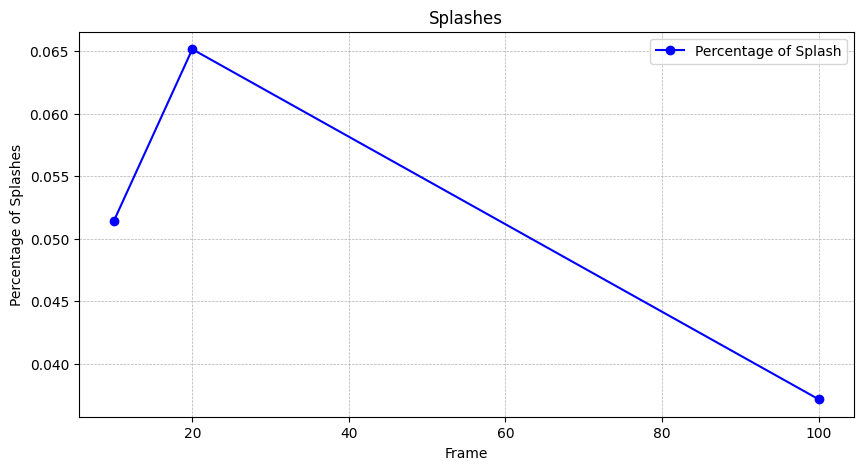

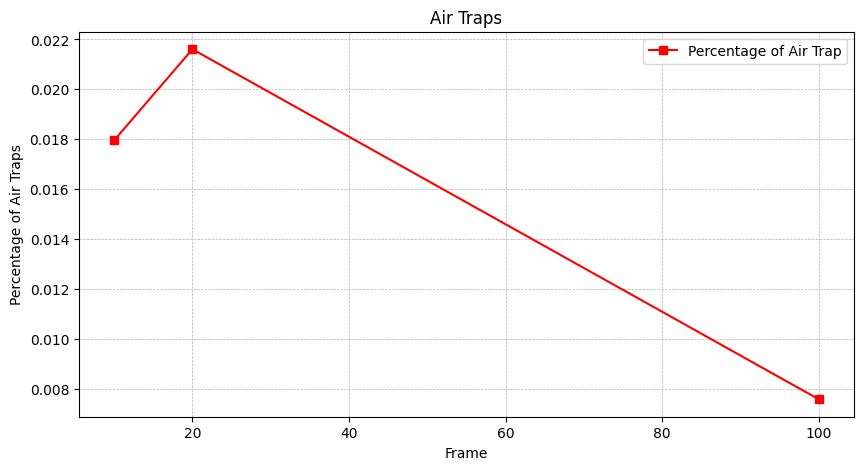

In [57]:
frames = np.array([item[0] for item in raw_data])
percentage_splash = np.array([item[1] for item in raw_data])
percentage_air_trap = np.array([item[2] for item in raw_data])
plt.figure(figsize=(10, 5))
plt.plot(frames, percentage_splash, marker='o', linestyle='-', color='b', label='Percentage of Splash')
plt.xlabel('Frame')
plt.ylabel('Percentage of Splashes')
plt.title('Splashes')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()
plt.figure(figsize=(10, 5))
plt.plot(frames, percentage_air_trap, marker='s', linestyle='-', color='r', label='Percentage of Air Trap')
plt.xlabel('Frame')
plt.ylabel('Percentage of Air Traps')
plt.title('Air Traps')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()